<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SECTION-1:-Prepare-Data" data-toc-modified-id="SECTION-1:-Prepare-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>SECTION 1: Prepare Data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Prepare-Time-Series-Datasets,-For-Hire-Vehicle-data-in-New-York-from-2015-to-2018" data-toc-modified-id="Prepare-Time-Series-Datasets,-For-Hire-Vehicle-data-in-New-York-from-2015-to-2018-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Prepare Time Series Datasets, For-Hire-Vehicle data in New York from 2015 to 2018</a></span></li><li><span><a href="#Plot-FHV-Data-From-2015-to-2018" data-toc-modified-id="Plot-FHV-Data-From-2015-to-2018-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Plot FHV Data From 2015 to 2018</a></span></li><li><span><a href="#Load-Data-and-Process-External-Features" data-toc-modified-id="Load-Data-and-Process-External-Features-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Load Data and Process External Features</a></span></li></ul></li></ul></li><li><span><a href="#SECTION-2:-Run-LSTM" data-toc-modified-id="SECTION-2:-Run-LSTM-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>SECTION 2: Run LSTM</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Create-Dataset-with-Sliding-Window" data-toc-modified-id="Create-Dataset-with-Sliding-Window-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Create Dataset with Sliding Window</a></span></li><li><span><a href="#Build-Model" data-toc-modified-id="Build-Model-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Build Model</a></span></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Prediction-and-Validation" data-toc-modified-id="Prediction-and-Validation-2.0.4"><span class="toc-item-num">2.0.4&nbsp;&nbsp;</span>Prediction and Validation</a></span></li><li><span><a href="#Brief-Conclusion-Between-LSTM-and-SARIMA" data-toc-modified-id="Brief-Conclusion-Between-LSTM-and-SARIMA-2.0.5"><span class="toc-item-num">2.0.5&nbsp;&nbsp;</span>Brief Conclusion Between LSTM and SARIMA</a></span></li></ul></li></ul></li></ul></div>

# SECTION 1: Prepare Data

The For-Hire Vehicle (“FHV”) trip records from 2015 to mid 2018 are downloaded from the NYC Taxi and Limousine Commission (TLC), https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page


NOTE: two extreme spikes exist in late 2018, trip records in 2019 also shows very different pattern, so not used here. 

In [33]:
import pandas as pd
from datetime import datetime
import numpy as np
import holidays
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
import warnings

warnings.filterwarnings('ignore')

### Prepare Time Series Datasets, For-Hire-Vehicle data in New York from 2015 to 2018
<b>daily number of trips from 2015 to 2018</b>

In [139]:
df_final = pd.DataFrame()
for dd in range(1, 13):
    file = 'fhv_tripdata_2015-' + ('%02d' % dd) + '.csv'
    print("current filename: ", file)
    
    df = pd.read_csv(file, usecols=['Pickup_date'])
    print(" " * 4 + "data record ", df.shape[0])
    
    df['Pickup_date'] = pd.to_datetime(df['Pickup_date'])
    df['time'] = df['Pickup_date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    df_count = pd.DataFrame(df['time'].value_counts()).sort_index()
    print(" " * 4 + "days in current file", df_count.shape[0], "days")
    
    df_final = pd.concat([df_final, df_count])

current filename:  fhv_tripdata_2015-01.csv
    data record  2746033
    days in current file 31 days
current filename:  fhv_tripdata_2015-02.csv
    data record  3126401
    days in current file 28 days
current filename:  fhv_tripdata_2015-03.csv
    data record  3281427
    days in current file 31 days
current filename:  fhv_tripdata_2015-04.csv
    data record  3917789
    days in current file 30 days
current filename:  fhv_tripdata_2015-05.csv
    data record  4296067
    days in current file 31 days
current filename:  fhv_tripdata_2015-06.csv
    data record  4253883
    days in current file 30 days
current filename:  fhv_tripdata_2015-07.csv
    data record  4394463
    days in current file 31 days
current filename:  fhv_tripdata_2015-08.csv
    data record  5283081
    days in current file 31 days
current filename:  fhv_tripdata_2015-09.csv
    data record  6654426
    days in current file 30 days
current filename:  fhv_tripdata_2015-10.csv
    data record  8672537
    days in c

In [ ]:
df_final = df_final.rename({'time': 'trips'}, axis=1)
df_final.to_csv('FHV_NY_tripdata_2015to2018.csv', mode='a', header=['Trips'],
                index=df_final.index.tolist(), index_label='Date')

<b> write/append data to csv file </b>

### Plot FHV Data From 2015 to 2018

[Text(0, 0.5, 'number of trips'), Text(0.5, 0, 'date'), Text(0.5, 1.0, '2015')]

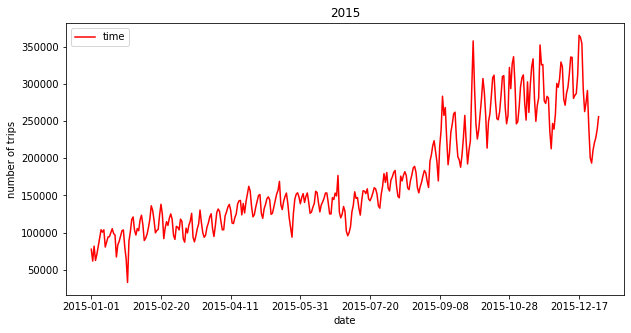

In [141]:
ax = df_final.plot(kind='line', figsize=(10, 5), style=['red'], marker='', linewidth=1.5, fontsize=10)
ax.set(xlabel='date', ylabel='number of trips', title='2015')

[Text(0, 0.5, 'number of trips'), Text(0.5, 0, 'date'), Text(0.5, 1.0, '2016')]

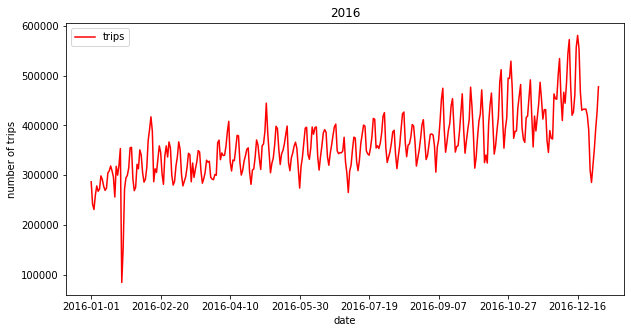

In [138]:
ax = df_final.plot(kind='line', figsize=(10, 5), style=['red'], marker='', linewidth=1.5, fontsize=10)
ax.set(xlabel='date', ylabel='number of trips', title='2016')

[Text(0, 0.5, 'number of trips'), Text(0.5, 0, 'date'), Text(0.5, 1.0, '2017')]

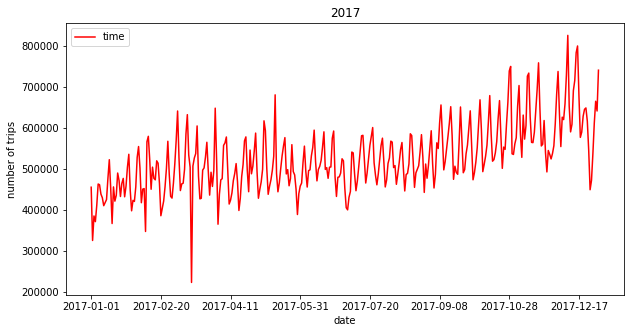

In [150]:
ax = df_final.plot(kind='line', figsize=(10, 5), style=['red'], marker='', linewidth=1.5, fontsize=10)
ax.set(xlabel='date', ylabel='number of trips', title='2017')

[Text(0, 0.5, 'number of trips'), Text(0.5, 0, 'date'), Text(0.5, 1.0, '2018')]

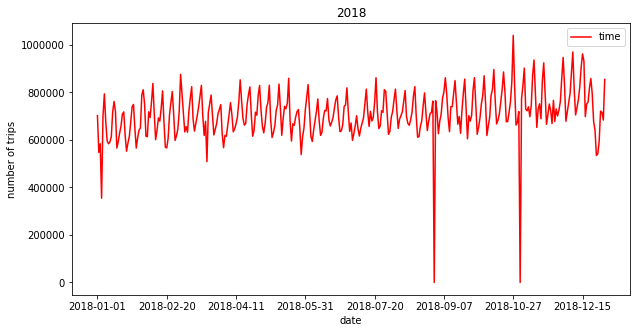

In [155]:
ax = df_final.plot(kind='line', figsize=(10, 5), style=['red'], marker='', linewidth=1.5, fontsize=10)
ax.set(xlabel='date', ylabel='number of trips', title='2018')

### Load Data and Process External Features

1. <b> adding holidays and weather events to provide nonlinear external features </b>
2. <b> trips are converted to log scale </b>

In [2]:
df = pd.read_csv('FHV_NY_tripdata_2015to2018.csv')
df.head()

,Date,Trips
0,2015-01-01,77789
1,2015-01-02,61832
2,2015-01-03,81955
3,2015-01-04,62691
4,2015-01-05,71063


In [3]:
df.shape

(1463, 2)

In [4]:
df = df.iloc[:-125]

In [5]:
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

[Text(0, 0.5, 'number of trips'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, '2015-2018')]

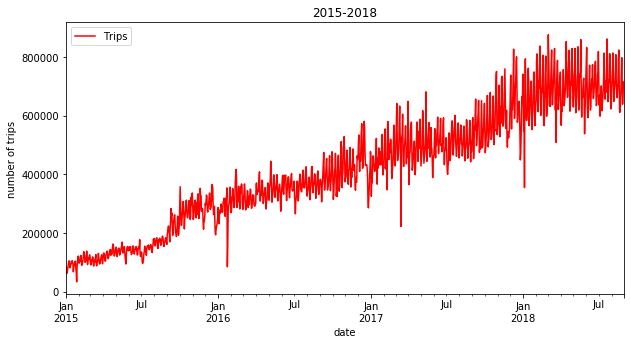

In [6]:
ax = df.plot(x='Date', y='Trips', kind='line', figsize=(10, 5), style=['red'], 
             marker='', linewidth=1.5, fontsize=10)
ax.set(xlabel='date', ylabel='number of trips', title='2015-2018')

1. <b> not stationary -- doesn't matter here </b>
2. <b> spikes -- assocaited with holidays or extreme weather </b>

In [7]:
record_weather = [datetime.strptime(date, "%Y-%m-%d") 
                  for date in ['2018-01-04', '2018-03-21','2017-03-14','2017-02-09','2016-01-23']]
record_holidays = [date for year in range(2015, 2019) 
                   for date, _ in sorted(holidays.US(years=year).items())]
df['holiday'] = np.where(df['Date'].isin(record_holidays), 1, 0)
df['bad_weather'] = np.where(df['Date'].isin(record_weather), 1, 0)

[Text(0, 0.5, 'number of trips'),
 Text(0.5, 0, 'date'),
 Text(0.5, 1.0, '2015-2018')]

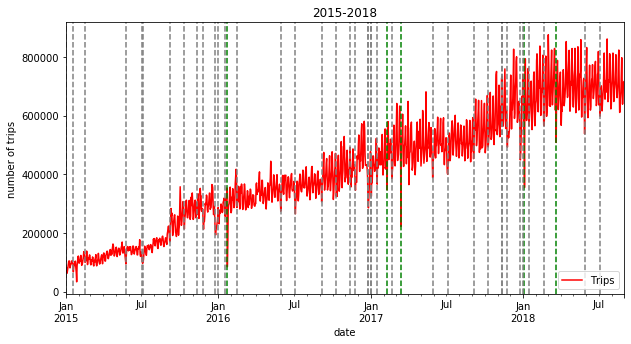

In [8]:
ax = df.plot(x='Date', y='Trips', kind='line', figsize=(10, 5), 
             style=['red'], marker='', linewidth=1.5, fontsize=10)
# add extreme weather
for rec in record_weather:
    ax.axvline(rec, color='green', linestyle='--')
# add holidays
for rec in record_holidays:
    ax.axvline(rec, color='gray', linestyle='--')
ax.set(xlabel='date', ylabel='number of trips', title='2015-2018')

In [9]:
df['next_holiday'] = df['holiday'].shift(-1)
df['next_bad_weather'] = df['bad_weather'].shift(-1)
df['next_holiday'].fillna(0, inplace=True)
df['next_bad_weather'].fillna(0, inplace=True)

df.head()

,Date,Trips,holiday,bad_weather,next_holiday,next_bad_weather
0,2015-01-01,77789,1,0,0.0,0.0
1,2015-01-02,61832,0,0,0.0,0.0
2,2015-01-03,81955,0,0,0.0,0.0
3,2015-01-04,62691,0,0,0.0,0.0
4,2015-01-05,71063,0,0,0.0,0.0


In [10]:
df['Trips'] = np.log(df['Trips'])
df.head()

,Date,Trips,holiday,bad_weather,next_holiday,next_bad_weather
0,2015-01-01,11.261755,1,0,0.0,0.0
1,2015-01-02,11.032176,0,0,0.0,0.0
2,2015-01-03,11.313926,0,0,0.0,0.0
3,2015-01-04,11.045973,0,0,0.0,0.0
4,2015-01-05,11.171322,0,0,0.0,0.0


# SECTION 2: Run LSTM
A Long-short Term Memory network (LSTM) is a type of recurrent neural network designed to overcome problems of basic RNNs, such as gradient vanishing and exploding, so the network can learn long-term dependencies. The model was proposed in 1997 by Sepp Hochreiter and Jürgen Schmidhuber and has been used widely in fields related to speech recognition, machine translation, speech synthesis, etc.

check paper "Deep and Confident Prediction for Time Series at Uber"

### Create Dataset with Sliding Window

1. 28-days sliding windows with step size equal to 1
2. for each batch, the first value is substracted to remove trend
3. logging to reduce exponential effect

In [11]:
def data_transform(df, look_back=1, forecast_horizon=1, batch_size=1):
    df_x, df_y = df[['Trips', 'next_holiday', 'next_bad_weather']], df['Trips']
    batch_x, batch_y, batch_offset = [], [], []
    for i in range(0, len(df) - look_back - forecast_horizon - batch_size + 1, batch_size):
        # put to small batch
        for j in range(batch_size):
            x = df_x.values[i + j:i + j + look_back, :]
            y = df_y.values[i + j + look_back:i + j + look_back + forecast_horizon]
            offset = x[0, 0]
            batch_x.append(np.array(x).reshape(look_back, -1))
            batch_y.append(np.array(y))
            batch_offset.append(np.array(offset))

        # format to ndarray
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        batch_offset = np.array(batch_offset)

        # substract the first value of each batch
        offsets = batch_offset.reshape(-1, 1)
        batch_x[:, :, 0] -= offsets
        batch_y -= offsets

        # return and reset
        yield batch_x, batch_y, batch_offset
        batch_x, batch_y, batch_offset = [], [], []

### Build Model

1. 2 LSTM layers with 128 units and 32 units, respectively. Then a fully connected layer with 1 output
2. dropout is added after each layer for BNN

In [12]:
class Model(nn.Module):
    def __init__(self, config):
        super(Model, self).__init__()
        self.hidden_size = 128
        self.bi = 1
        self.lstm = nn.LSTM(config.get('features'), self.hidden_size, 1, dropout=0.1,
                            bidirectional=bool(self.bi - 1), batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_size, self.hidden_size // 4, 1, dropout=0.1,
                             bidirectional=bool(self.bi - 1), batch_first=True)
        self.dense = nn.Linear(self.hidden_size // 4, config.get('forecast_horizon'))
        self.loss_fn = nn.MSELoss()

    def forward(self, x, batch_size=32):
        hidden = self.init_hidden(batch_size)
        output, _ = self.lstm(x, hidden)
        output = F.dropout(output, p=0.5, training=True)
        state = self.init_hidden2(batch_size)
        output, state = self.lstm2(output, state)
        output = self.dense(state[0].squeeze(0))
        return output

    def init_hidden(self, batch_size):
        # initialise our hidden state
        h0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size))
        c0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size))
        return h0, c0

    def init_hidden2(self, batch_size):
        h0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size // 4))
        c0 = Variable(torch.zeros(self.bi, batch_size, self.hidden_size // 4))
        return h0, c0

    def loss(self, pred, truth):
        return self.loss_fn(pred, truth)

### Train Model

In [37]:
batch_size = 1
forecast_horizon = 1
look_back = 28
config = dict(features=3, forecast_horizon=1)
model = Model(config)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 30

model.train()
train_true_y = []
train_pred_y = []
for epoch in tqdm(range(n_epochs)):
    ep_loss = []
    train_data = data_transform(df[df.Date < datetime.strptime('2018-01-01', "%Y-%m-%d")], 
                                look_back=look_back, forecast_horizon=1, batch_size=batch_size)
    for i, batch in enumerate(train_data):
        print("Epoch {}: loss={:0.4f}".format(epoch, np.mean(ep_loss)), end="\r")
        try:
            batch = [torch.Tensor(x) for x in batch]
        except:
            break
        out = model.forward(batch[0].float(), batch_size)
        loss = model.loss(out, batch[1].float())
        if epoch == n_epochs - 1:
            train_true_y.append((batch[1] + batch[2]).detach().numpy().reshape(-1))
            train_pred_y.append((out + batch[2]).detach().numpy().reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ep_loss.append(loss.item())

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Epoch 0: loss=0.0194

  3%|██▊                                                                                | 1/30 [00:16<08:00, 16.58s/it]

  7%|█████▌                                                                             | 2/30 [00:34<07:55, 16.97s/it]

Epoch 2: loss=0.0122

 10%|████████▎                                                                          | 3/30 [00:53<07:55, 17.60s/it]

Epoch 3: loss=0.0105

 13%|███████████                                                                        | 4/30 [01:12<07:45, 17.92s/it]

Epoch 4: loss=0.0091

 17%|█████████████▊                                                                     | 5/30 [01:29<07:26, 17.86s/it]

Epoch 5: loss=0.0083

 20%|████████████████▌                                                                  | 6/30 [01:47<07:05, 17.74s/it]

Epoch 6: loss=0.0076

 23%|███████████████████▎                                                               | 7/30 [02:04<06:46, 17.66s/it]

 27%|██████████████████████▏                                                            | 8/30 [02:26<06:57, 18.96s/it]

 30%|████████████████████████▉                                                          | 9/30 [02:50<07:05, 20.26s/it]

 33%|███████████████████████████▎                                                      | 10/30 [03:11<06:52, 20.61s/it]

Epoch 10: loss=0.0071

 37%|██████████████████████████████                                                    | 11/30 [03:31<06:28, 20.44s/it]

Epoch 11: loss=0.0067

 40%|████████████████████████████████▊                                                 | 12/30 [03:51<06:04, 20.24s/it]

 43%|███████████████████████████████████▌                                              | 13/30 [04:10<05:36, 19.78s/it]

Epoch 13: loss=0.0068

 47%|██████████████████████████████████████▎                                           | 14/30 [04:28<05:10, 19.43s/it]

Epoch 14: loss=0.0063

 50%|█████████████████████████████████████████                                         | 15/30 [04:46<04:45, 19.04s/it]

 53%|███████████████████████████████████████████▋                                      | 16/30 [05:05<04:23, 18.79s/it]

Epoch 16: loss=0.0060

 57%|██████████████████████████████████████████████▍                                   | 17/30 [05:23<04:02, 18.67s/it]

Epoch 17: loss=0.0058

 60%|█████████████████████████████████████████████████▏                                | 18/30 [05:41<03:43, 18.59s/it]

Epoch 18: loss=0.0057

 63%|███████████████████████████████████████████████████▉                              | 19/30 [06:00<03:24, 18.60s/it]

Epoch 19: loss=0.0058

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [06:19<03:06, 18.63s/it]

Epoch 20: loss=0.0053

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [06:38<02:48, 18.71s/it]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [06:57<02:30, 18.83s/it]

Epoch 22: loss=0.0056

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [07:16<02:12, 18.92s/it]

Epoch 23: loss=0.0061

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [07:35<01:54, 19.12s/it]

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [07:55<01:36, 19.26s/it]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [08:15<01:17, 19.44s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [08:35<00:58, 19.54s/it]

Epoch 27: loss=0.0051

 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [08:53<00:38, 19.31s/it]

Epoch 28: loss=0.0052

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [09:12<00:19, 19.05s/it]

Epoch 29: loss=0.0050

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [09:30<00:00, 19.03s/it]

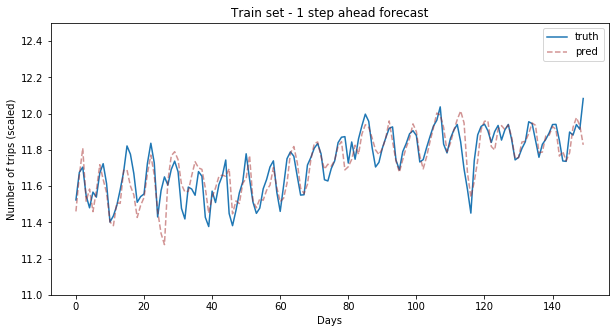

In [38]:
import matplotlib.pyplot as plt

train_true_y = np.array(train_true_y)
train_pred_y = np.array(train_pred_y)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.array(train_true_y[:150]).reshape(-1), label='truth')
ax.plot(train_pred_y[:150], label='pred', c='brown', linestyle='--', alpha=0.5)
ax.set(title="Train set - 1 step ahead forecast", ylabel="Number of trips (scaled)", xlabel="Days", ylim=(11.0, 12.5))
ax.legend();

### Prediction and Validation

In [51]:
test_true_y, test_pred_y = [], []
n_epochs = 30
for epoch in range(n_epochs):
    epoch_loss = []
    preds = []
    test_data = data_transform(df[df.Date >= datetime.strptime('2018-01-01', "%Y-%m-%d")],
                               look_back, forecast_horizon, batch_size)
    for i, batch in enumerate(test_data):
        try:
            batch = [torch.Tensor(x) for x in batch]
        except:
            break
        out = model.forward(batch[0].float(), batch_size)
        loss = model.loss(out, batch[1].float())
        epoch_loss.append(loss.item())
        if epoch == 0:
            test_true_y.append((batch[1] + batch[2]).detach().numpy().reshape(-1))
        preds.append((out + batch[2]).detach().numpy().reshape(-1))
    print('Epoch {}/{}: loss={:0.4f}'.format(epoch+1, n_epochs, np.mean(epoch_loss), end='\r'))
    test_pred_y.append(preds)

Epoch 1/30: loss=0.0025
Epoch 2/30: loss=0.0025
Epoch 3/30: loss=0.0033
Epoch 4/30: loss=0.0024
Epoch 5/30: loss=0.0024
Epoch 6/30: loss=0.0027
Epoch 7/30: loss=0.0025
Epoch 8/30: loss=0.0023
Epoch 9/30: loss=0.0028
Epoch 10/30: loss=0.0026
Epoch 11/30: loss=0.0024
Epoch 12/30: loss=0.0027
Epoch 13/30: loss=0.0023
Epoch 14/30: loss=0.0027
Epoch 15/30: loss=0.0021
Epoch 16/30: loss=0.0026
Epoch 17/30: loss=0.0023
Epoch 18/30: loss=0.0025
Epoch 19/30: loss=0.0024
Epoch 20/30: loss=0.0025
Epoch 21/30: loss=0.0026
Epoch 22/30: loss=0.0026
Epoch 23/30: loss=0.0023
Epoch 24/30: loss=0.0024
Epoch 25/30: loss=0.0027
Epoch 26/30: loss=0.0023
Epoch 27/30: loss=0.0023
Epoch 28/30: loss=0.0022
Epoch 29/30: loss=0.0023
Epoch 30/30: loss=0.0023


In [52]:
test_true_y = np.array(np.exp(test_true_y))
test_pred_y = np.array(np.exp(test_pred_y))
mean = np.mean(test_pred_y, axis=0).reshape(-1)
std = np.std(test_pred_y, axis=0).reshape(-1)

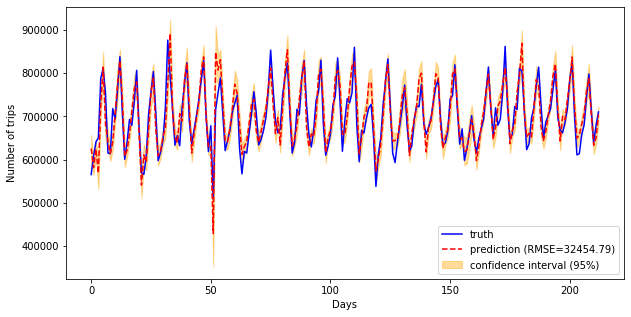

In [53]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test_true_y.reshape(-1), c='blue', label='truth')
rmse_ = np.sqrt(mean_squared_error(test_true_y, mean))
ax.plot(mean, label='prediction (RMSE={:0.2f})'.format(rmse_), c='red', linestyle='--')
ax.fill_between([*range(len(test_true_y.reshape(-1)))], mean-2*std, mean+2*std, 
                label='confidence interval (95%)', color='orange', alpha=.4)
ax.set(xlabel="Days", ylabel="Number of trips")
ax.legend();

In [54]:
def evaluate_metrics(y, pred):
    results = pd.DataFrame({'r2_score': r2_score(y, pred)}, index=[0])
    results['Mean_Absolute_Error'] = mean_absolute_error(y, pred)
    results['Median_Absolute_Error'] = median_absolute_error(y, pred)
    results['MSE'] = mean_squared_error(y, pred)
    results['MSLE'] = mean_squared_log_error(y, pred)
    results['MAPE'] = np.mean(np.abs((y - pred) / y)) * 100
    results['RMSE'] = np.sqrt(results['MSE'])
    return results

In [55]:
evaluation = evaluate_metrics(test_true_y, mean)
evaluation

,r2_score,Mean_Absolute_Error,Median_Absolute_Error,MSE,MSLE,MAPE,RMSE
0,0.777351,25179.201172,20688.125,1.053313e+09,0.002163,11.418638,32454.789062
